In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt

In [2]:
!pip install seaborn==0.12.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import seaborn as sns
sns.__version__

'0.12.0'

In [4]:
pd.__version__

'1.3.4'

In [5]:
perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240728/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/aligned_msl512b512cls_s128/processed/tl_tf_multi_coronaviridae_s_uniref90_sars_cov_2_aligned.csv_WIV04.csv")
#perturbation_output_filepath = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240710/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_cls_hybrid_attn_fnn_2l_lr1e-4/aligned_msl128_s64/processed/tl_tf_multi_coronaviridae_s_uniref90_sars_cov_2_aligned.csv_WIV04.csv")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig"]

In [6]:
def get_perturbation_output(perturbation_output_filepath):
    df = pd.read_csv(perturbation_output_filepath)
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]

    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    df["orig_y_pred"] = orig_pred_class
    df["new_y_pred"] = df[classes].idxmax(axis=1)
    return df

In [7]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)

In [8]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

In [9]:
def get_distribution_df(df, orig_token, perturb_pos, perturbation_id, perturbation_id_label):
    print(f"Perturbation id = {perturbation_id}")
    # perturbation df
    perturbation_df = df[df["perturbation_id"] == perturbation_id].copy()
    perturbation_df.loc[:, "type"] = "mutation"
    perturbation_id_x = perturbation_id[:-1]
    perturbation_id_x += "X"
    print(perturbation_id_x)
    # not perturbation df: all other perturbations in all sequences
#     non_perturbation_df = df[df["perturbation_id"] != perturbation_id].copy()
#     non_perturbation_df.loc[:, "type"] = "all seq, all non-mutatn perturbatns"
    perturbation_id_x_df = df[df["perturbation_id"] == perturbation_id_x].copy()
    perturbation_id_x_df["type"] = "mutation w/ new token = X"
    # all other perturbations in the same position in all sequences
    pos_non_perturbation_df = df[(df["perturb_seq_pos"] == perturb_pos) &
                                 (df["perturbation_id"] != perturbation_id_x) &
                                 (df["perturbation_id"] != perturbation_id)].copy()
    pos_non_perturbation_df.loc[:, "type"] = "all seq, same pos non-mutation perturbations"
    
    # sequences with original token
    sequence_w_orig_token_df = df[(df["orig_token"] == orig_token) & (df["perturb_seq_pos"] == perturb_pos)].copy()
    sequence_w_orig_token_ids = list(sequence_w_orig_token_df["uniref90_id"].unique())
    
    # all other perturbations in sequences with original token
#     swo_non_perturbation_df = non_perturbation_df[non_perturbation_df["uniref90_id"].isin(sequence_w_orig_token_ids)].copy()
#     swo_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, all non-mutatn perturbatns"
    
    # all other perturbations in the same positions in sequences with the original token
    swo_pos_non_perturbation_df = sequence_w_orig_token_df[(sequence_w_orig_token_df["perturbation_id"] != perturbation_id) &
                                                           (sequence_w_orig_token_df["new_token"] != "X")].copy()
    swo_pos_non_perturbation_df.loc[:, "type"] = "seq w/ orig token, same pos non-mutation perturbations"
    
#     print(f"perturbation = {perturbation_df.shape}")
#     print(f"all seq, all non-perturbations = {non_perturbation_df.shape}")
#     print(f"all seq, same pos non-perturbations = {pos_non_perturbation_df.shape}")
#     print(f"sequence_w_orig_token_df = {sequence_w_orig_token_df.shape}")
#     print(f"seq w/ orig token, all non-perturbations = {swo_non_perturbation_df.shape}")
#     print(f"seq w/ orig token, same pos non-perturbations = {swo_pos_non_perturbation_df.shape}")
    
    # result_df = pd.concat([perturbation_df, non_perturbation_df, pos_non_perturbation_df, swo_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df = pd.concat([perturbation_df, perturbation_id_x_df, pos_non_perturbation_df, swo_pos_non_perturbation_df])
    result_df["label"] = perturbation_id_label
    return result_df

In [10]:
perturbed_output_df = get_perturbation_output(perturbation_output_filepath)
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

perturbed_output_df shape = (31826, 17)



#### WIV04 reference sequence

In [11]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/sarscov2/aligned/uniref90/coronaviridae_s_uniref90_sars_cov_2_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

,uniref90_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [12]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(len(wiv04_aligned_seq))
wiv04_aligned_seq

2418


'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [13]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [14]:
perturbed_output_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
0,4.530627e-07,0.000003,0.005619,0.000001,6.495229e-07,0.000077,0.994293,0.000006,WIV04,Human,L,688,I,-3.300000e-06,3.300000e-06,Human,Human,226
1,4.578197e-07,0.000003,0.005621,0.000001,6.568529e-07,0.000078,0.994290,0.000006,WIV04,Human,S,948,W,-6.050000e-06,6.050000e-06,Human,Human,373
2,4.451795e-07,0.000003,0.005548,0.000001,6.397356e-07,0.000076,0.994365,0.000005,WIV04,Human,V,1632,I,6.905000e-05,6.905000e-05,Human,Human,642
3,4.490093e-07,0.000003,0.005616,0.000001,6.432958e-07,0.000077,0.994296,0.000006,WIV04,Human,C,2379,V,0.000000e+00,0.000000e+00,Human,Human,1248
4,4.490453e-07,0.000003,0.005616,0.000001,6.433528e-07,0.000077,0.994296,0.000006,WIV04,Human,S,94,A,0.000000e+00,0.000000e+00,Human,Human,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31821,4.462794e-07,0.000003,0.005594,0.000001,6.397428e-07,0.000077,0.994319,0.000006,WIV04,Human,E,1965,O,2.226000e-05,2.226000e-05,Human,Human,918
31822,4.475335e-07,0.000003,0.005615,0.000001,6.410382e-07,0.000077,0.994297,0.000006,WIV04,Human,D,1882,B,7.000000e-07,7.000000e-07,Human,Human,843
31823,4.490093e-07,0.000003,0.005616,0.000001,6.432958e-07,0.000077,0.994296,0.000006,WIV04,Human,Y,2317,Q,0.000000e+00,0.000000e+00,Human,Human,1215
31824,4.446416e-07,0.000003,0.005614,0.000001,6.365311e-07,0.000077,0.994298,0.000006,WIV04,Human,F,867,M,2.000000e-06,2.000000e-06,Human,Human,347


In [15]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [16]:
perturbed_output_df[perturbed_output_df["perturb_seq_pos"]==493]

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos
1389,4.491829e-07,0.000003,0.005617,0.000001,6.435457e-07,0.000077,0.994296,0.000006,WIV04,Human,Q,1314,J,-7.400000e-07,7.400000e-07,Human,Human,493
3121,4.516590e-07,0.000003,0.005622,0.000001,6.472198e-07,0.000077,0.994290,0.000006,WIV04,Human,Q,1314,W,-6.050000e-06,6.050000e-06,Human,Human,493
4855,4.494535e-07,0.000003,0.005617,0.000001,6.439505e-07,0.000077,0.994295,0.000006,WIV04,Human,Q,1314,R,-1.200000e-06,1.200000e-06,Human,Human,493
5136,4.487379e-07,0.000003,0.005615,0.000001,6.429082e-07,0.000077,0.994297,0.000006,WIV04,Human,Q,1314,X,9.000000e-07,9.000000e-07,Human,Human,493
7616,4.521043e-07,0.000003,0.005622,0.000001,6.478843e-07,0.000077,0.994290,0.000006,WIV04,Human,Q,1314,C,-6.760000e-06,6.760000e-06,Human,Human,493
10050,4.498751e-07,0.000003,0.005618,0.000001,6.445774e-07,0.000077,0.994294,0.000006,WIV04,Human,Q,1314,G,-1.940000e-06,1.940000e-06,Human,Human,493
10825,4.499969e-07,0.000003,0.005618,0.000001,6.447643e-07,0.000077,0.994294,0.000006,WIV04,Human,Q,1314,T,-2.050000e-06,2.050000e-06,Human,Human,493
12775,4.530459e-07,0.000003,0.005623,0.000001,6.493309e-07,0.000077,0.994289,0.000006,WIV04,Human,Q,1314,A,-7.240000e-06,7.240000e-06,Human,Human,493
13644,4.488950e-07,0.000003,0.005616,0.000001,6.431247e-07,0.000077,0.994297,0.000006,WIV04,Human,Q,1314,S,1.000000e-07,1.000000e-07,Human,Human,493
13796,4.487537e-07,0.000003,0.005616,0.000001,6.428990e-07,0.000077,0.994296,0.000006,WIV04,Human,Q,1314,K,0.000000e+00,0.000000e+00,Human,Human,493


# Overview

### Distribution of Human class difference

In [17]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [18]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 0 (0.0)
Distribution of full perturbation output
n=31826
       start       end  count  percentage
0  -0.031883 -0.030156      1    0.003142
1  -0.030156 -0.028429      0    0.000000
2  -0.028429 -0.026701      0    0.000000
3  -0.026701 -0.024974      0    0.000000
4  -0.024974 -0.023247      1    0.003142
5  -0.023247 -0.021520      0    0.000000
6  -0.021520 -0.019792      0    0.000000
7  -0.019792 -0.018065      0    0.000000
8  -0.018065 -0.016338      0    0.000000
9  -0.016338 -0.014611      0    0.000000
10 -0.014611 -0.012883      0    0.000000
11 -0.012883 -0.011156      1    0.003142
12 -0.011156 -0.009429      2    0.006284
13 -0.009429 -0.007701      7    0.021995
14 -0.007701 -0.005974     11    0.034563
15 -0.005974 -0.004247     22    0.069126
16 -0.004247 -0.002520    104    0.326777
17 -0.002520 -0.000792    421    1.322818
18 -0.000792  0.000935  31236   98.146170
19  0.000935  0.002662     20    0.062842

>>>>>>>

/tmp/ipykernel_3553979/1309478090.py:7: RuntimeWarning: invalid value encountered in long_scalars
  hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})


<Figure size 432x288 with 0 Axes>

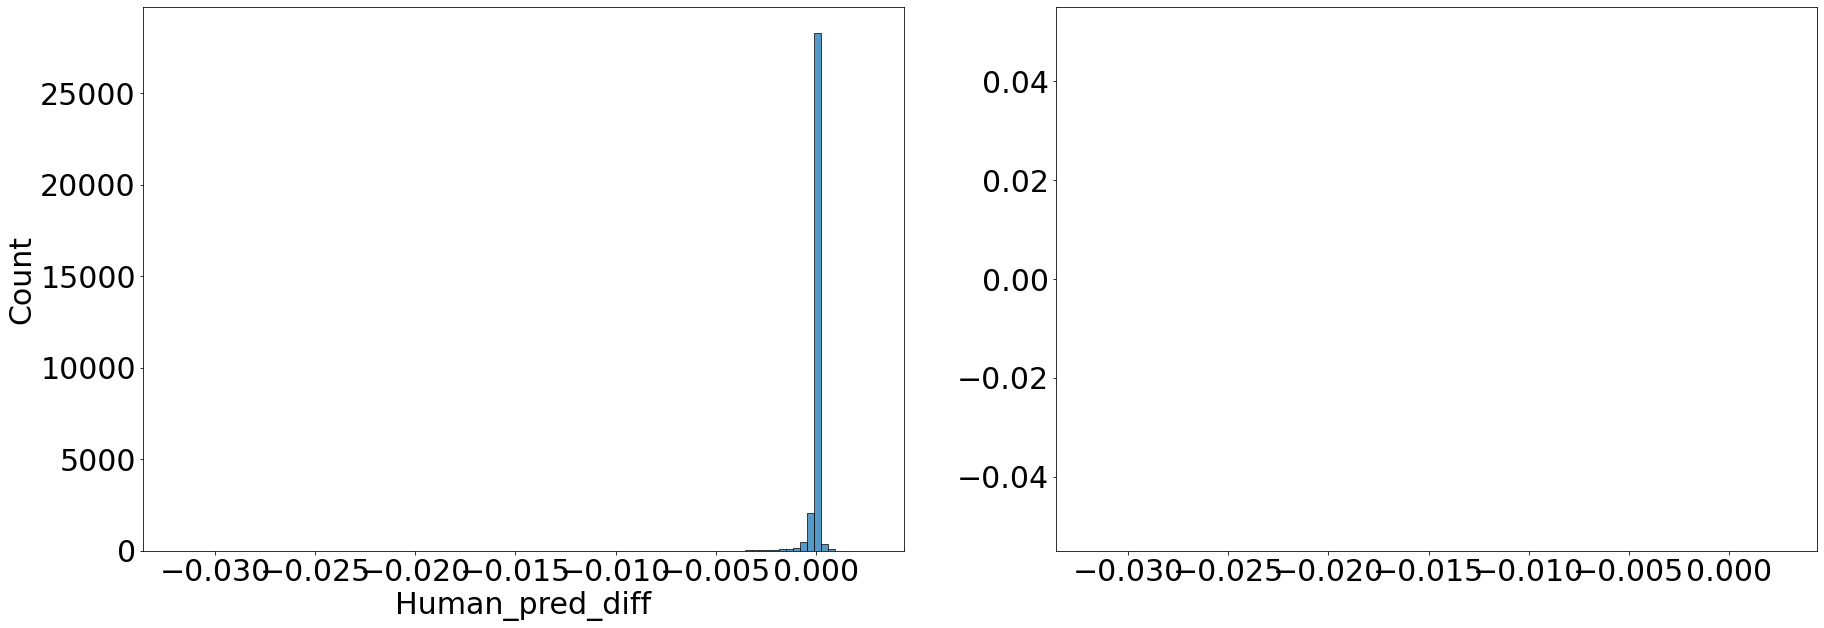

In [19]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

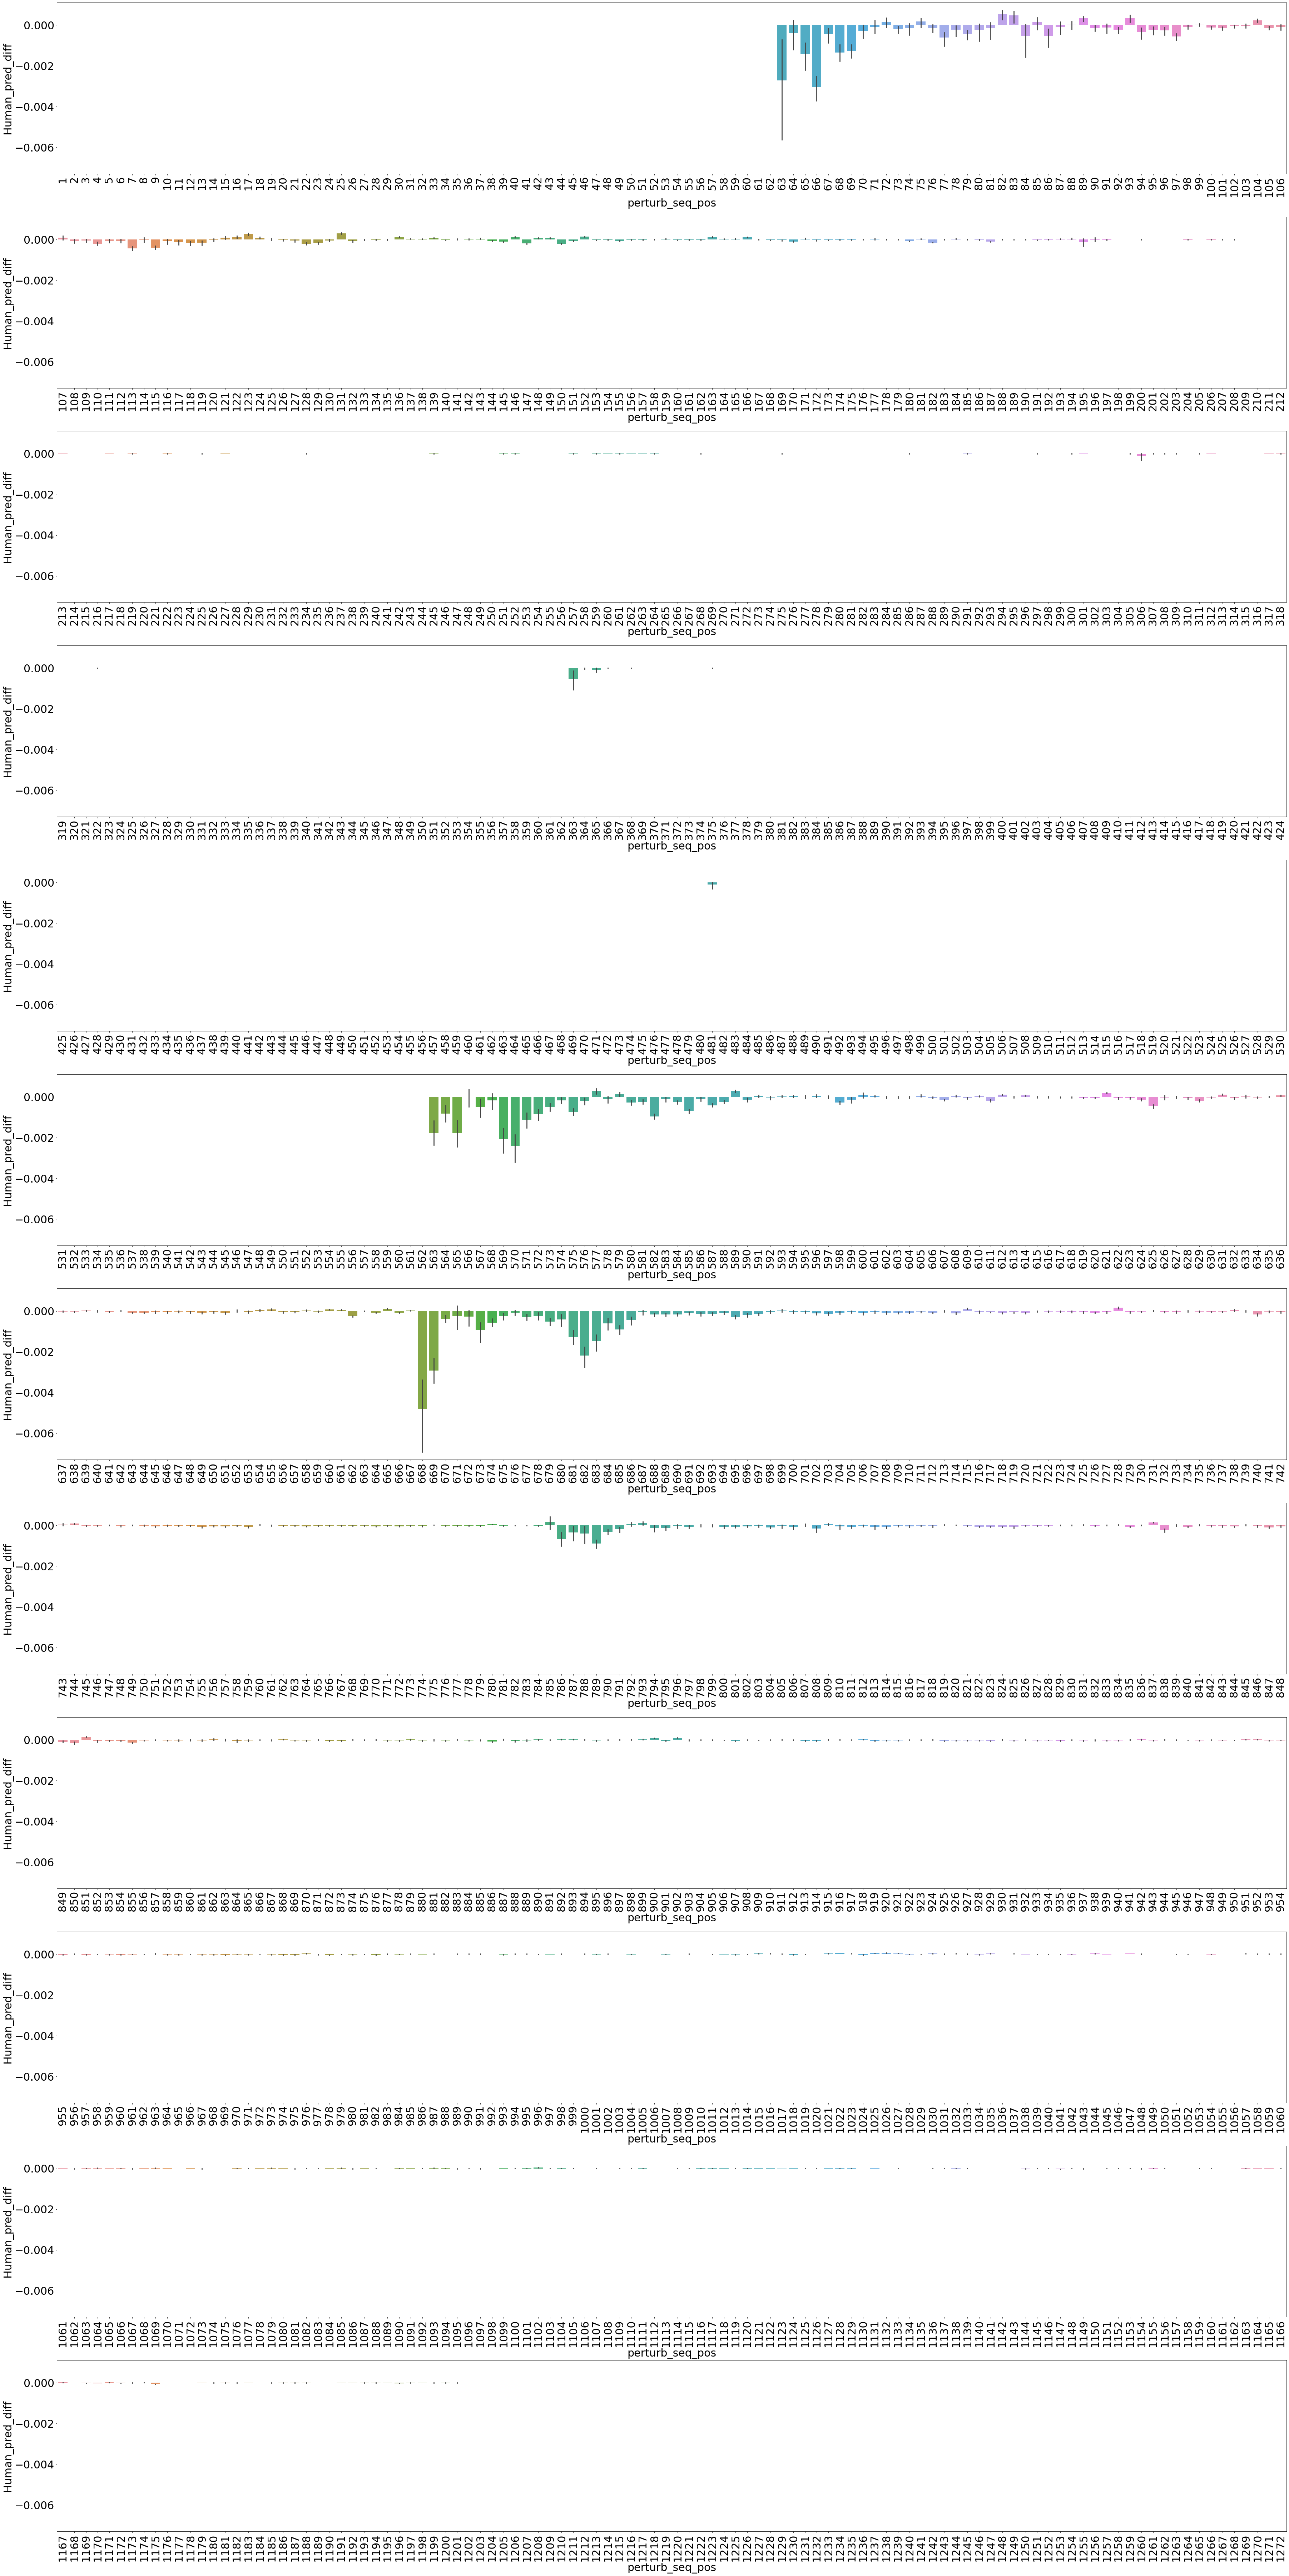

In [20]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
n = 12
fig, axs = plt.subplots(n, 1, figsize=(50, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(sorted(perturbed_output_df["perturb_seq_pos"].unique())), n)

for i in range(n):
    sns.barplot(perturbed_output_df[perturbed_output_df["perturb_seq_pos"].isin(bins[i])], x="perturb_seq_pos", y=pred_diff_col, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: mean=0 and variance=0

In [21]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
len(cut_off_pos_1)


1201

<Figure size 432x288 with 0 Axes>

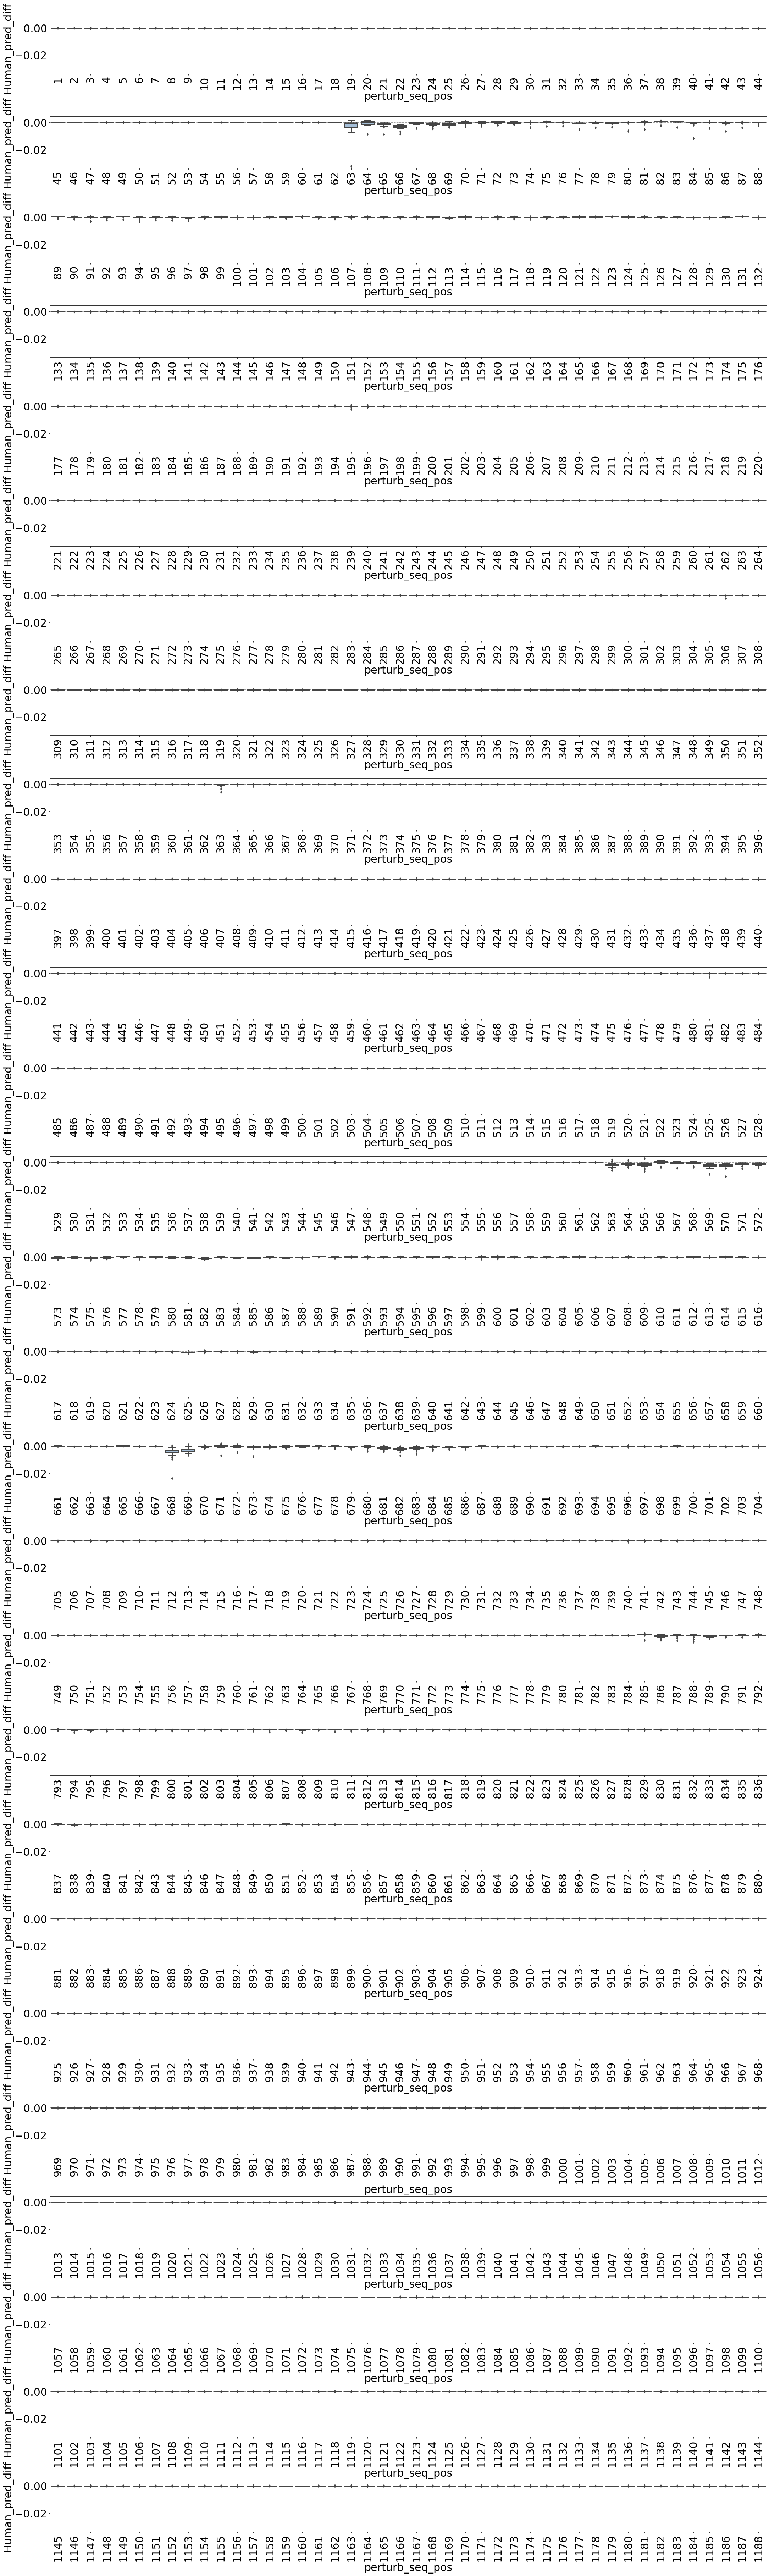

In [22]:
plt.clf()
n = 27
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(n, 1, figsize=(30, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(cut_off_pos_1), n)

for i in range(n):
    sns.boxplot(data=cut_off_df_1[cut_off_df_1["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [23]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 1201
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 0
1 intersection 2: 0
1 minus 2: 1201
2 minus 1: 0
is 2 subset of 1: True


ValueError: min() arg is an empty sequence

<Figure size 432x288 with 0 Axes>

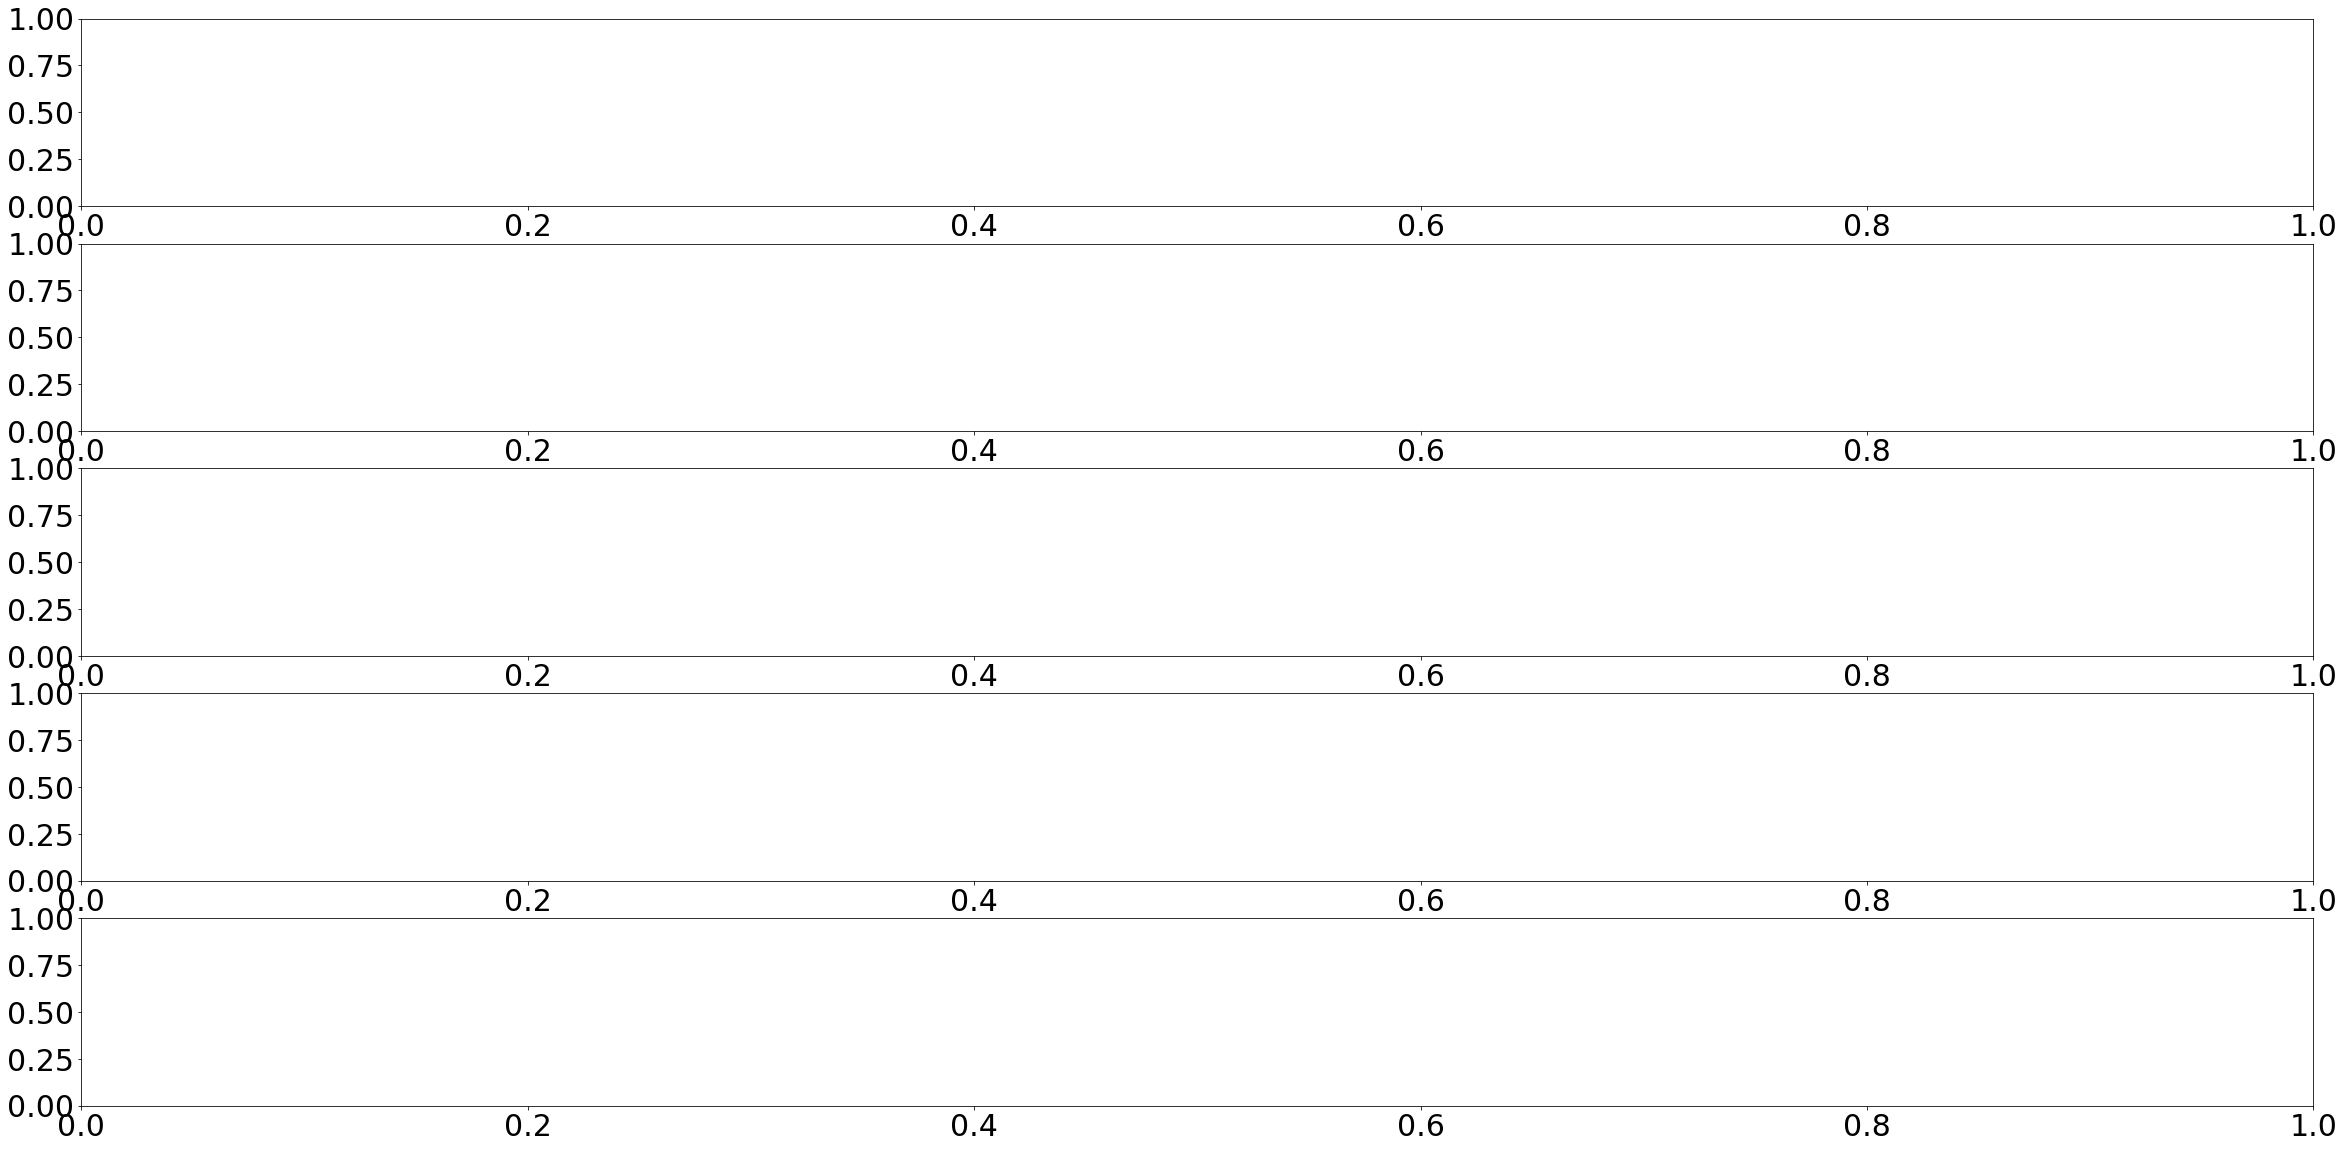

In [24]:
plt.clf()
n = 5
fig, axs = plt.subplots(n, 1, figsize=(40, 20), sharey=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

bins = get_uniformly_divided_position_bins(list(cut_off_pos_2), n)

for i in range(n):
    sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")

plt.tight_layout(pad=.1)
plt.show()


## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [25]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]
non_x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] != "X"].copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No non overlapping boxes found


<Figure size 432x288 with 0 Axes>

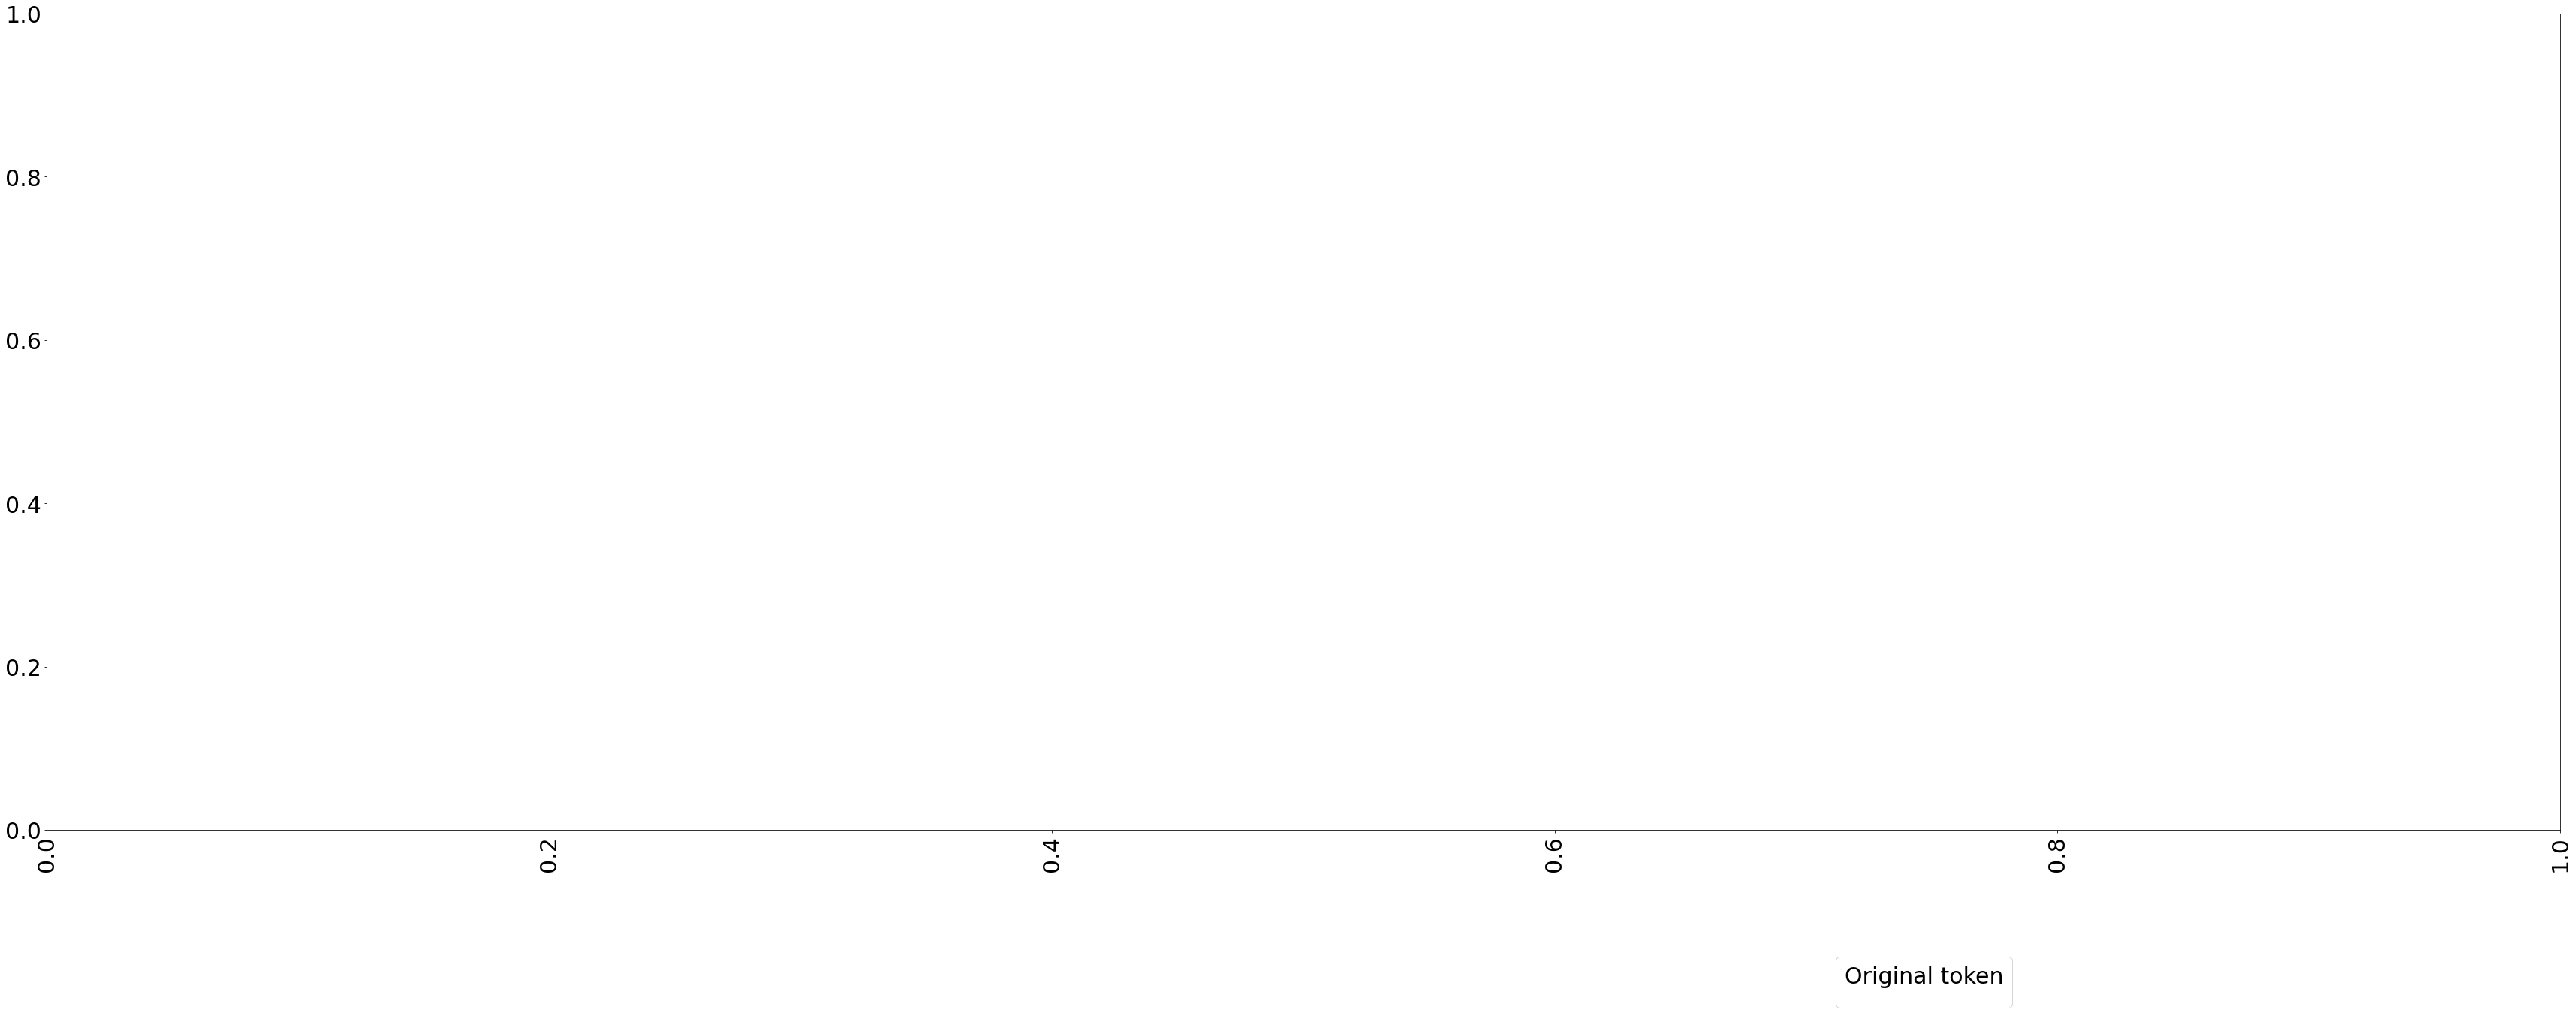

In [26]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(60, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [27]:
annotate_df

,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,orig_y_pred,new_y_pred,perturb_seq_pos,perturbation_id


### Mutations with new token NOT = X

In [28]:
print(f"New token != X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

New token != X = (0, 19)
Number of unique mutations = 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No non overlapping boxes found


<Figure size 432x288 with 0 Axes>

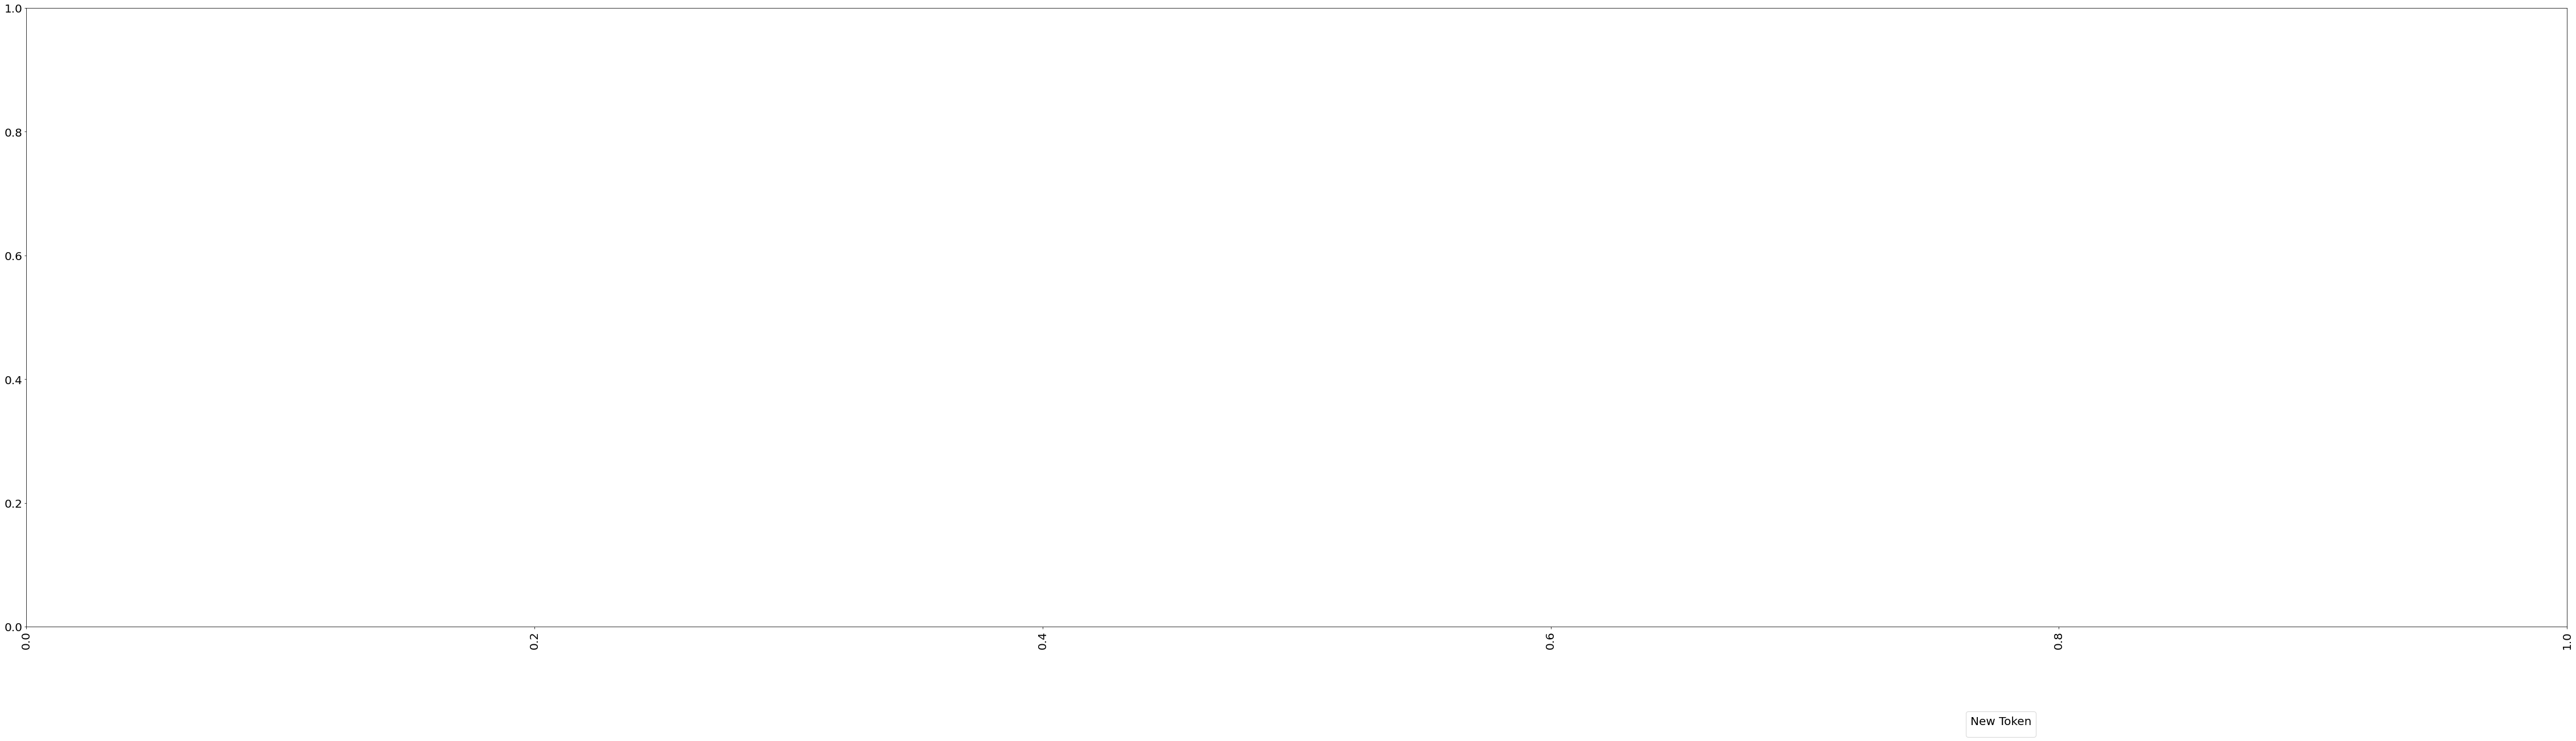

In [29]:
plt.clf()
plt.figure(figsize=(80, 20))
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [30]:
cut_off_df_2["perturbation_id"].nunique()

0

ValueError: min() arg is an empty sequence

<Figure size 432x288 with 0 Axes>

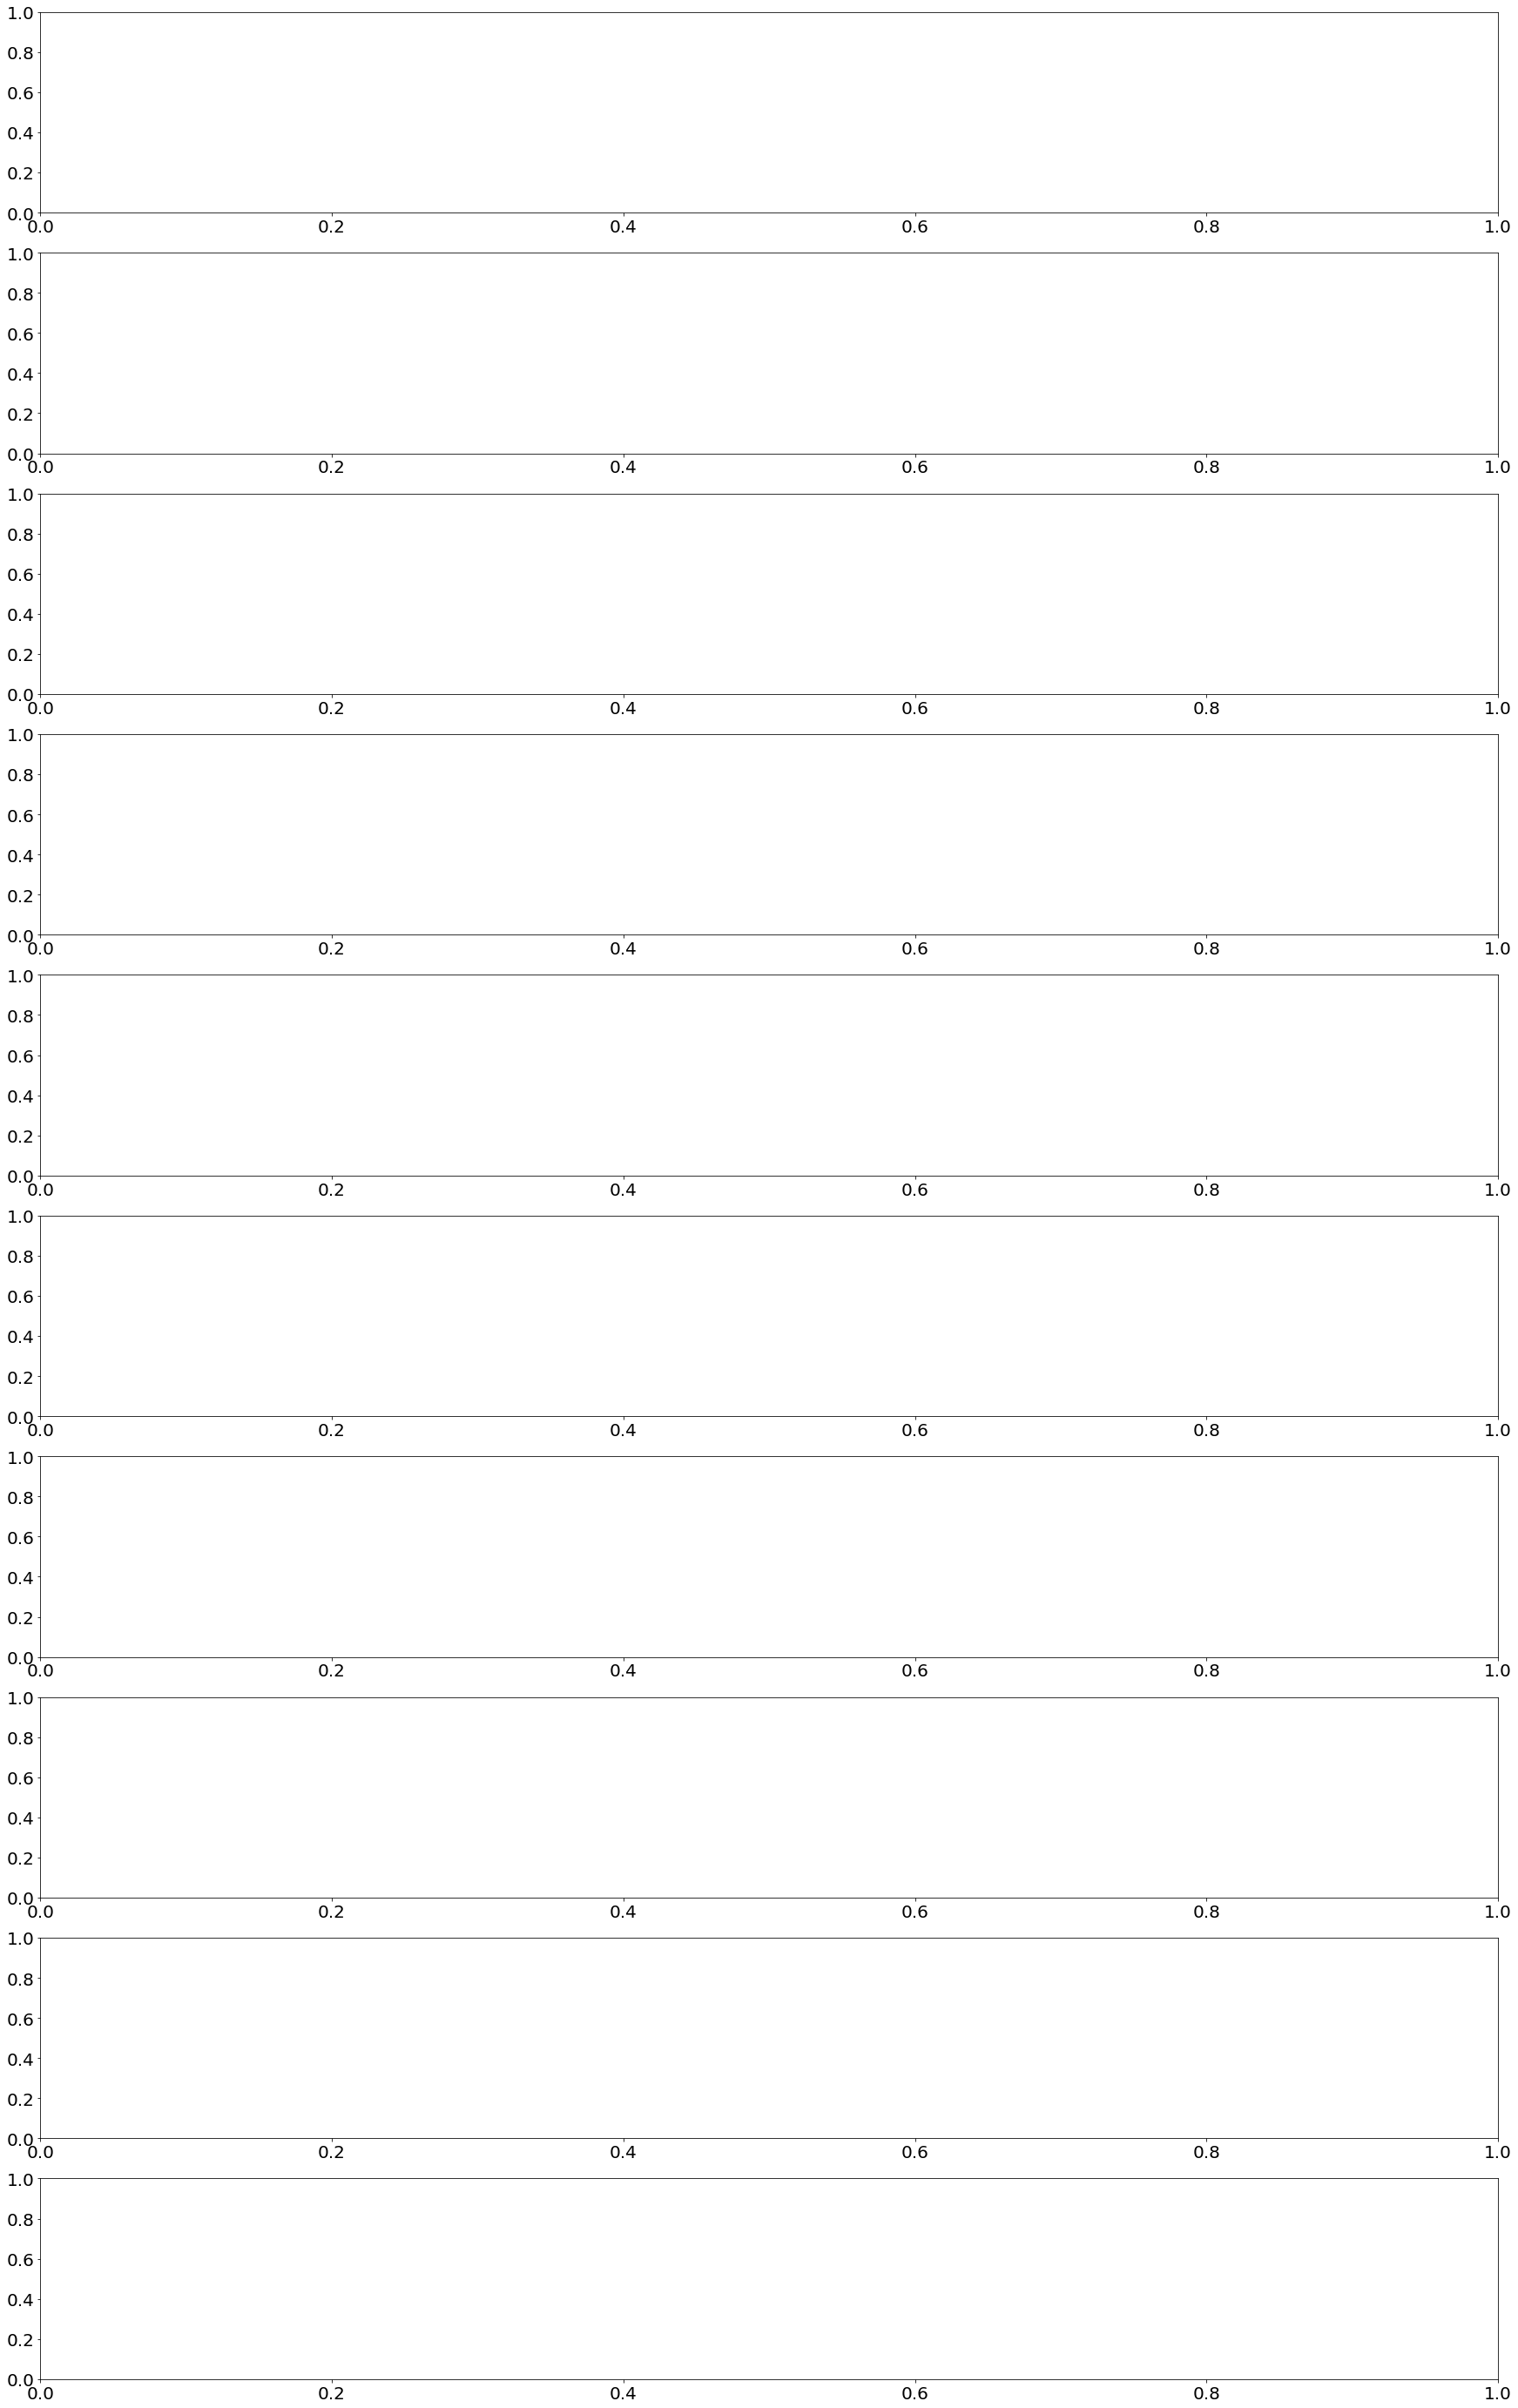

In [31]:
plt.clf()
n = 10
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
fig, axs = plt.subplots(n, 1, figsize=(30, 50), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbation_ids), n)

for i in range(n):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(bins[i])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[i], orient="v", order=bins[i],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.2)
plt.show()

## Known Mutations

In [32]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..","..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_WIV04_mutations_grouped_filtered.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
#s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] + s_mutations_df["pos"].astype("str") + s_mutations_df["new_token"]
s_mutations_df

,spike_mutations,pango_lineage,variant_count
0,A222V,['B.1.177'],1
1,A264D,"['JN.1', 'JN.4']",2
2,A27S,"['BA.2', 'BA.2.12.1', 'BA.2.75', 'JN.1', 'BA.4...",27
3,A475V,"['XBB.1.5', 'JD.1.1', 'JD.1.1.1', 'GW.5.1.1', ...",5
4,A570D,['B.1.1.7'],1
...,...,...,...
129,V83A,"['EG.5.1', 'XBB.1.5', 'JD.1.1', 'JD.1.1.1', 'J...",16
130,W152C,"['B.1.427, B.1.429']",1
131,W152R,['BA.2.75'],1
132,Y248H,"['XBB.1.5', 'JD.1.1.1']",2


In [33]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

In [34]:
mutation_variant_heatmap_df = pd.read_csv(os.path.join(os.getcwd(), "..", "..", "..","..", "..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_WIV04_mutations_filtered_heatmap.csv"))
mutation_variant_heatmap_df.set_index("spike_mutations", inplace=True)
mutation_variant_heatmap_df

,B.1.1.1.C37,B.1.1.28.1,B.1.1.28.2,B.1.1.28.3,B.1.1.318,B.1.1.7,B.1.177,B.1.214.2,B.1.351,B.1.375,...,HK.3.2,HV.1,JD.1.1,JD.1.1.1,JG.3,JN.1,JN.4,XBB,XBB.1,XBB.1.5
spike_mutations,,,,,,,,,,,,,,,,,,,,,
A222V,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A264D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
A27S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
A475V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0
A570D,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V83A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0
W152C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W152R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["spike_mutations"])]

# s_mutations_df = s_mutations_df.merge(known_mutations_df[["perturbation_id", "label"]], on="perturbation_id")
# s_mutations_df

<Figure size 432x288 with 0 Axes>

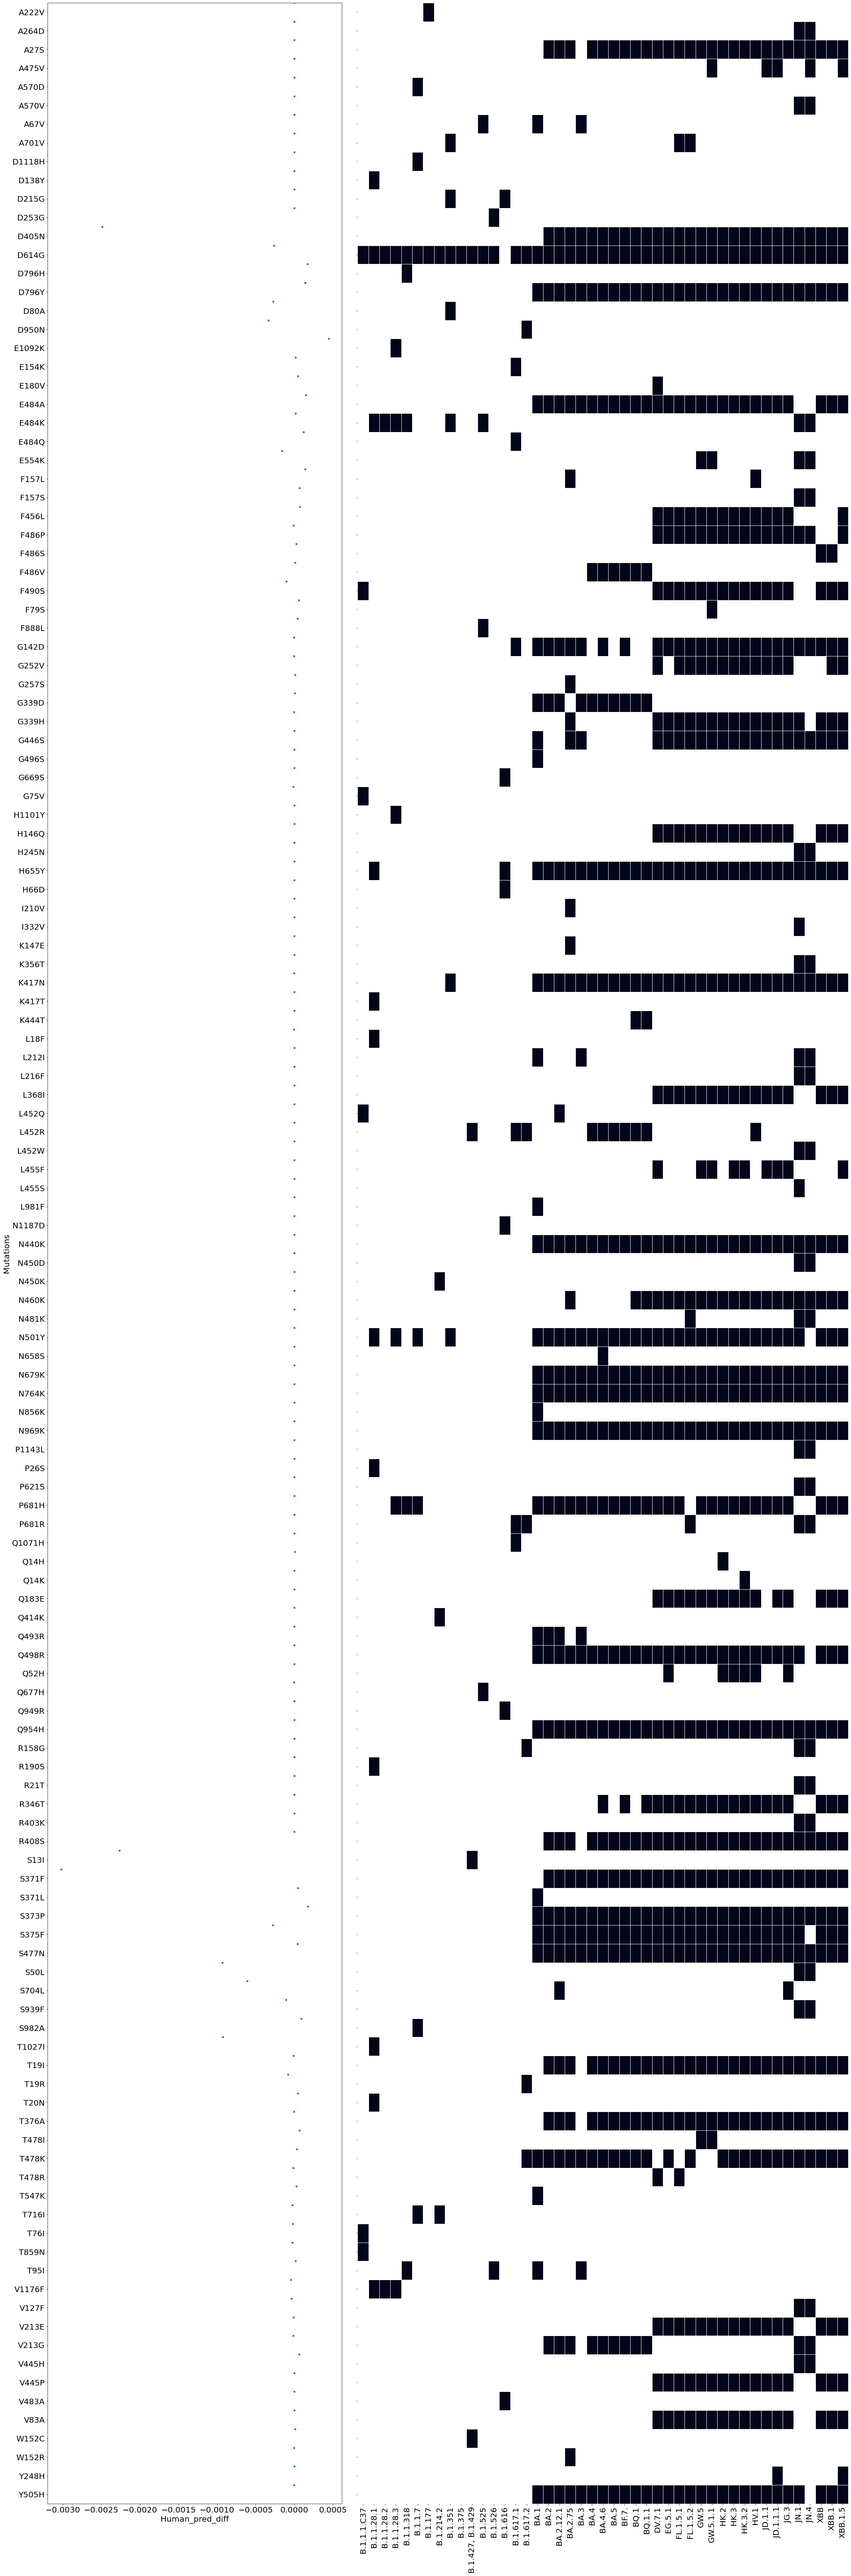

In [36]:
plt.clf()
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

fig, axs = plt.subplots(1, 2, figsize=(30, 90), sharex=False, sharey=True, gridspec_kw={'width_ratios': [.6, 1]})


sns.stripplot(data=known_mutations_df, y="perturbation_id", x="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["perturbation_id"].unique(), ax=axs[0])
    
axs[0].set_ylabel("Mutations")
    #axs.tick_params(axis='x', rotation=90)
sns.heatmap(mutation_variant_heatmap_df, linewidth=.5, ax=axs[1], cmap=sns.cm.rocket_r, cbar=False, vmin=0, vmax=1)
# plt.tight_layout(pad=.2)
axs[1].set_ylabel("")
plt.tight_layout()
plt.show()

### Identified and Known Mutations

In [37]:
identified_mutations = set(cut_off_df_2["perturbation_id"].unique())
known_mutations = set(s_mutations_df["spike_mutations"].unique())
print(f"identified_mutations = {len(identified_mutations)}")
print(f"known_mutations = {len(known_mutations)}")
print(f"intersection = {identified_mutations.intersection(known_mutations)}")
intersection = list(identified_mutations.intersection(known_mutations))

identified_mutations = 0
known_mutations = 134
intersection = set()
